In [5]:
import numpy as np
import numpy as np
from scipy.io import arff
from matplotlib import pyplot as plt

In [6]:
def get_distance(x1, x2):
    """Get Euclidean distane"""
    return np.sqrt(np.sum((x1 - x2) ** 2))

In [7]:
def kmeans(X, k, max_iters):
  
    centroids = X[np.random.choice(range(len(X)), k, replace=False)]

    converged = False
    
    current_iter = 0

    while (not converged) and (current_iter < max_iters):

        cluster_list = [[] for i in range(len(centroids))]

        for x in X:  # Go through each data point
            distances_list = []
            for c in centroids:
                distances_list.append(get_distance(c, x))
            cluster_list[int(np.argmin(distances_list))].append(x)

        cluster_list = list((filter(None, cluster_list)))

        prev_centroids = centroids.copy()

        centroids = []

        for j in range(len(cluster_list)):
            centroids.append(np.mean(cluster_list[j], axis=0))

        pattern = np.abs(np.sum(prev_centroids) - np.sum(centroids))

        converged = (pattern == 0)

        current_iter += 1

    return np.array(centroids), [np.std(x) for x in cluster_list], cluster_list


In [8]:
class RBF:

    def __init__(self, X, y, tX, ty, num_of_classes,
                 k, std_from_clusters=True):
        self.X = X
        self.y = y

        self.tX = tX
        self.ty = ty

        self.number_of_classes = num_of_classes
        self.k = k
        self.std_from_clusters = std_from_clusters

    def convert_to_one_hot(self, x, num_of_classes):
        arr = np.zeros((len(x), num_of_classes))
        for i in range(len(x)):
            c = int(x[i])
            arr[i][c] = 1
        return arr

    def rbf(self, x, c, s):
        distance = get_distance(x, c)
        return np.exp(-(distance/ s) ** 2)

    def rbf_list(self, X, centroids, std_list):
        RBF_list = []
        for x in X:
            RBF_list.append([self.rbf(x, c, s) for (c, s) in zip(centroids, std_list)])
        return np.array(RBF_list)


    def fit(self):

        self.centroids, self.std_list, _ = kmeans(self.X, self.k, max_iters=1000)

        if not self.std_from_clusters:
            dMax = np.max([get_distance(c1, c2) for c1 in self.centroids for c2 in self.centroids])
            self.std_list = np.repeat(dMax / np.sqrt(2 * self.k), self.k)

        RBF_X = self.rbf_list(self.X, self.centroids, self.std_list)

        self.w = np.linalg.pinv(RBF_X.T @ RBF_X) @ RBF_X.T @ self.convert_to_one_hot(self.y, self.number_of_classes)

        RBF_list_tst = self.rbf_list(self.tX, self.centroids, self.std_list)

        self.pred_ty = RBF_list_tst @ self.w

        self.pred_ty = np.array([np.argmax(x) for x in self.pred_ty])

        diff = self.pred_ty - self.ty

        print('Accuracy: ', len(np.where(diff == 0)[0]) / len(diff))


In [9]:
data, meta = arff.loadarff("./eeg+eye+state/EEG Eye State.arff")
data = np.array(data.tolist())
# data = np.char.decode(data.astype(str), 'utf-8')
data = data.astype(np.float32)

train_x = data[0:12000, 0:14]
train_y = data[0:12000, 14]

test_x = data[12000:14980, 0:14]
test_y = data[12000:14980, 14]


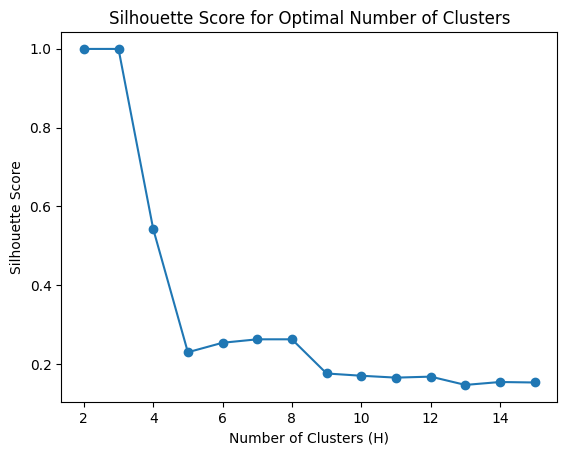

In [11]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from matplotlib import pyplot as plt


max_clusters = 15
max_iters = 100
silhouette_scores = []

for h in range(2, max_clusters + 1):
    centroids, stds, cluster_list = kmeans(data, h, max_iters)
    labels = np.concatenate([i * np.ones(len(cluster_list[i])) for i in range(len(cluster_list))])
    
    flat_clusters = np.concatenate(cluster_list)

# Calculate silhouette score
    silhouette_avg = silhouette_score(flat_clusters, labels)
    silhouette_scores.append(silhouette_avg)
    # print("Silhouette Score:", silhouette_avg)

# max_clusters = 10
# silhouette_scores = []
# for h in range(2, max_clusters + 1):
#     kmeans = KMeans(n_clusters=h, random_state=0, n_init="auto")
#     labels = kmeans.fit_predict(data)
#     silhouette_scores.append(silhouette_score(data, labels))

plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (H)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal Number of Clusters')
plt.show()

In [ ]:
RBF_CLASSIFIER = RBF(train_x, train_y, test_x, test_y, num_of_classes=2,
                     k=15, std_from_clusters=False)

RBF_CLASSIFIER.fit()

Accuracy:  0.5184563758389261


In [ ]:
max_clusters = 10
inertias = []
for h in range(1, max_clusters + 1):
    kmeans = kmeans(n_clusters=h, random_state=42,n_init="auto", max_iter=100)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1, max_clusters + 1), inertias, marker='o')
plt.xlabel('Number of Clusters (H)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()


TypeError: 'KMeans' object is not callable